## Prepare train_data and test_data

In [1]:
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [2]:
X,y = datasets.load_breast_cancer(as_frame=True,return_X_y=True)
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=335)

## Make HyperGBM experiment with default settings and run it

In [3]:
from hypergbm import make_experiment

### Input Data

,X_train.shape,y_train.shape,X_eval.shape,y_eval.shape,X_test.shape,Task
0,"(398, 30)","(398,)",None,None,None,binary(2)


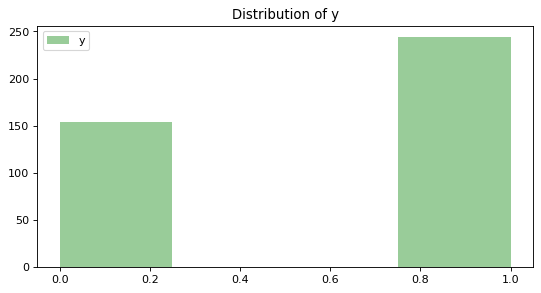

## Data Clean

### Initliazed parameters

,key,value
0,cv,True
1,data_cleaner_args,"{'nan_chars': None, 'correct_object_dtype': Tr..."
2,name,data_clean
3,train_test_split_strategy,None


### Fitted parameters

,key,value
0,input_features,"[mean radius, mean texture, mean perimeter, me..."
1,selected_features,"[mean radius, mean texture, mean perimeter, me..."
2,unselected_features,[]
3,X_train.shape,"(398, 30)"
4,y_train.shape,"(398,)"
5,X_eval.shape,None
6,y_eval.shape,None
7,X_test.shape,None
8,unselected_reason,{}
9,kept/dropped feature count,30/0


### Elapsed

* 0.014 seconds

## Space Searching

### Initliazed parameters

,key,value
0,cv,True
1,name,space_searching
2,num_folds,3


#### Experiment Settings:

HyperGBM(searcher=EvolutionSearcher(space_fn=GeneralSearchSpaceGenerator(n_estimators=200), population_size=30, sample_size=10, regularized=True, optimize_direction='max', random_state=RandomState(MT19937) at 0x7F2471967C00), callbacks=[EarlyStoppingCallback(max_no_improvement_trials=10, mode='max', time_limit=3599.985197544098), NotebookCallback(), ProgressiveCallback(), FitCrossValidationCallback()], reward_metric='precision', task='binary', discriminator=PercentileDiscriminator(percentile=50, history=TrialHistory(direction='max'), optimize_direction='max'))

,X,y,X_eval,y_eval,cv,num_folds,max_trials,trail_store,fit_kwargs
0,"(398, 30)","(398,)",None,None,True,3,10,None,{}


#### Trials Summary:

,Trial No.,Previous reward,Best trial,Best reward,Total elapsed,Valid trials,Max trials
0,10,0.96371,1,0.963855,31.955321,10,10


#### Best Trial:

key,value
signature,ac5cf3e5734e7aea7bcc82faa3a46cee
vectors,"[2, 3, 1, 3, 0, 3, 0]"
0-estimator_options.hp_or,2
1-numeric_imputer_0.strategy,most_frequent
2-numeric_scaler_optional_0.hp_opt,True
3-Module_CatBoostEstimator_1.learning_rate,0.1
4-Module_CatBoostEstimator_1.depth,3
5-Module_CatBoostEstimator_1.l2_leaf_reg,20
6-numeric_or_scaler_0.hp_or,0


#### Top trials:

,Trial No.,Reward,Elapsed,Space Vector
0,1,0.963855,0.721201,"[2, 3, 1, 3, 0, 3, 0]"
1,10,0.963710,13.270483,"[2, 1, 1, 1, 3, 0, 0]"
2,3,0.963415,0.128742,"[0, 2, 1, 0, 120, 2, 3, 2, 3, 0]"
3,6,0.959514,12.560283,"[2, 1, 0, 0, 3, 4]"
4,8,0.958678,0.388942,"[1, 0, 0, 3, 1, 0, 2, 1, 3, 4]"


search:   0%|          | 0/10 [00:00<?, ?it/s]

fit_cross_validation:   0%|          | 0/3 [00:00<?, ?it/s]

### Fitted parameters

,key,value
0,input_features,"[mean radius, mean texture, mean perimeter, me..."
1,best_reward,0.963855
2,history,"TrialHistory(direction='max', size=10, succeed..."


### Elapsed

* 31.982 seconds

## Final Ensemble

### Initliazed parameters

,key,value
0,ensemble_size,20
1,name,final_ensemble
2,scorer,"make_scorer(precision_score, average=binary)"


### Fitted parameters

,0,1
0,weights,"[0.2, 0.3, 0.2, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,scores,"[0.963855421686747, 0.967479674796748, 0.96747..."
2,best_stack,"[0, 2, 3, 1, 3, 3, 1, 3, 3, 1, 2, 0, 1, 2, 0, ..."
3,hits,"{0: 4, 2: 4, 3: 6, 1: 6}"
4,ensemble_size,20


### Elapsed

* 0.246 seconds

CPU times: user 5min 16s, sys: 4.18 s, total: 5min 21s
Wall time: 32.4 s


In [4]:
%%time
train_data = pd.concat([X_train,y_train],axis=1)
experiment = make_experiment(train_data, target='target', reward_metric='precision')
estimator = experiment.run()

In [5]:
estimator

Pipeline(steps=[('data_clean',
                 DataCleanStep(cv=True,
                               data_cleaner_args={'correct_object_dtype': True,
                                                  'drop_columns': None,
                                                  'drop_constant_columns': True,
                                                  'drop_duplicated_columns': False,
                                                  'drop_idness_columns': True,
                                                  'drop_label_nan_rows': True,
                                                  'int_convert_to': 'float',
                                                  'nan_chars': None,
                                                  'reduce_mem_usage': False},
                               name='data_clean')),
                ('estimator',
                 GreedyEnsemble(..., 0.967479674796748, 0.967479674796748, 0.9676113360323887, 0.9676113360323887, 0.9676113360323887, 0.96774193548

## Export the trained model

In [6]:
import pickle
with open('model.pkl','wb') as f:
    pickle.dump( estimator,f)

## Scoring with sklearn

In [7]:
from sklearn.metrics import get_scorer

scorer=get_scorer('precision')
# scorer=get_scorer('accuracy')
# scorer = get_scorer('roc_auc_ovo')
# sc=get_scorer('recall')
score = scorer(estimator,X_test,y_test)
score

0.9652173913043478

In [8]:
from sklearn.metrics import classification_report

y_pred=estimator.predict(X_test)
print(classification_report(y_test, y_pred, digits=5))

              precision    recall  f1-score   support

           0    0.96429   0.93103   0.94737        58
           1    0.96522   0.98230   0.97368       113

    accuracy                        0.96491       171
   macro avg    0.96475   0.95667   0.96053       171
weighted avg    0.96490   0.96491   0.96476       171



## Scoring with Hypernets.tabular toolbox

In [9]:
from hypernets.tabular.metrics import calc_score

preds=estimator.predict(X_test)
proba=estimator.predict_proba(X_test)

scores = calc_score(y_test,preds,proba,task='binary', metrics=['auc','accuracy','f1','recall','precision'] )
scores

{'auc': 0.9813854134879463,
 'accuracy': 0.9649122807017544,
 'f1': 0.9736842105263158,
 'recall': 0.9823008849557522,
 'precision': 0.9652173913043478}